In [1]:
import numpy as np
from math import gcd
from functools import reduce
import matplotlib.pyplot as plt
import heapq
import random
from tqdm import tqdm

In [2]:
def gcd_list(nums):
    return reduce(gcd, nums)


def frobenius_number_nijenhuis(numbers):
    numbers = sorted(numbers)
    min_num = numbers[0]
    n = min_num
    if min_num == 1:
        return 0
    edges = [[] for _ in range(n)]
    temp_g = [{} for _ in range(n)]
    for i in range(n):
        for num in numbers:
            v = (num + i) % n
            if v not in temp_g[i] or temp_g[i][v] > num:
                temp_g[i][v] = num
    for i in range(n):
        for v, w in temp_g[i].items():
            edges[i].append((v, w))
    INF = float('inf')
    dist = [INF] * n
    dist[0] = 0
    heap = [(0, 0)]
    while heap:
        d_v, v = heapq.heappop(heap)
        if d_v != dist[v]:
            continue
        for u, w in edges[v]:
            if dist[u] > dist[v] + w:
                dist[u] = dist[v] + w
                heapq.heappush(heap, (dist[u], u))
    max_dist = max(dist[1:]) if n > 1 else 0
    return max_dist - n


def simulate_path_graph(edge_lengths: list[int]) -> tuple[int, list[int]]:
    points = [[0, 1]]
    stabilization_times = [-1] * len(edge_lengths)
    vertex_positions = [0]
    for i in range(len(edge_lengths)):
        vertex_positions.append(vertex_positions[-1] + edge_lengths[i])
    total_length = vertex_positions[-1]
    t = 1
    max_points = sum(edge_lengths)
    while True:
        for point in points:
            point[0] += point[1]
        new_points = []
        for point in points:
            if point[0] in {0, total_length}:
                point[1] *= -1
            elif point[0] in vertex_positions:
                if sum(1 for p in points if p[0] == point[0]) == 1:
                    new_points.append([point[0], -point[1]])
        points.extend(new_points)
        for i in range(len(edge_lengths)):
            count = 0
            for point in points:
                pos, dr = point
                if vertex_positions[i] < pos < vertex_positions[i + 1]:
                    count += 1
                elif pos == vertex_positions[i] and dr == 1:
                    count += 1
                elif pos == vertex_positions[i + 1] and dr == -1:
                    count += 1
            if count == edge_lengths[i] and stabilization_times[i] == -1:
                stabilization_times[i] = t
        if len(points) == max_points:
            return t, stabilization_times
        t += 1


def generate_coprime_lengths(n, low=1, high=20):
    while True:
        lengths = [random.randint(low, high) for _ in range(n)]
        if gcd_list(lengths) == 1:
            return lengths

Сбор данных для 25: 100%|██████████| 150/150 [05:40<00:00,  2.27s/it]


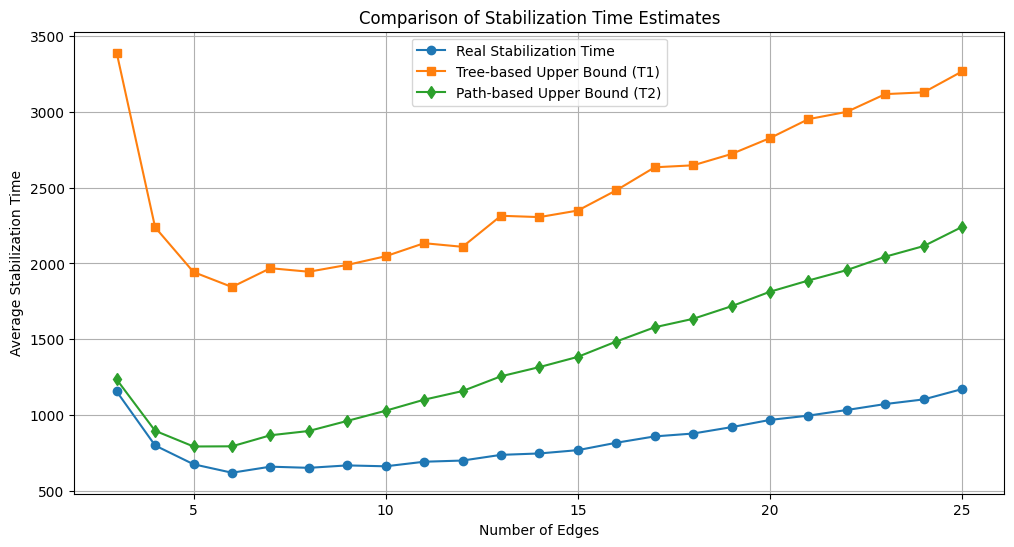

In [3]:
min_edges, max_edges = 3, 25
num_samples = 150
edge_low, edge_high = 5, 80

avg_real, avg_T1, avg_T2 = [], [], []

for n_edges in range(min_edges, max_edges + 1):
    real_times, T1_est, T2_est = [], [], []
    for _ in tqdm(range(num_samples), f"Сбор данных для {n_edges}"):
        lengths = generate_coprime_lengths(n_edges, edge_low, edge_high)
        real_time, _ = simulate_path_graph(lengths)
        real_times.append(real_time)

        w = [sum(lengths[:i]) for i in range(1, n_edges + 1)]
        g1 = frobenius_number_nijenhuis(w)
        T1 = 2 * (g1 + max(w))
        T1_est.append(T1)

        g2 = frobenius_number_nijenhuis(lengths)
        term1 = sum(lengths[:-1]) + 2 * lengths[-1] + 2 * g2
        term2 = 0
        for k in range(n_edges):
            left_sum = sum(lengths[:k])
            right_sum = sum(lengths[k + 1:])
            candidate = left_sum + 3 * lengths[k] + 2 * right_sum + 2 * g2
            term2 = max(term2, candidate)
        T2 = max(term1, term2)
        T2_est.append(T2)

    avg_real.append(np.mean(real_times))
    avg_T1.append(np.mean(T1_est))
    avg_T2.append(np.mean(T2_est))

n_range = list(range(min_edges, max_edges + 1))
plt.figure(figsize=(12, 6))
plt.plot(n_range, avg_real, 'o-', label='Real Stabilization Time')
plt.plot(n_range, avg_T1, 's-', label='Tree-based Upper Bound (T1)')
plt.plot(n_range, avg_T2, 'd-', label='Path-based Upper Bound (T2)')
plt.xlabel('Number of Edges')
plt.ylabel('Average Stabilization Time')
plt.title('Comparison of Stabilization Time Estimates')
plt.legend()
plt.grid(True)
plt.show()